In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import random

from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.fft import fft2, fftshift

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hyp3_sar_fpath = '/Users/kaipak/datasets/SAR_comparison/hyp3_decibel/S1A_IW_GRDH_1SDV_20190105T135310_20190105T135335_025343_02CE16_CD52_VV_landmask.tif'
snap_sar_fpath = '/Users/kaipak/datasets/SAR_comparison/snap_beta_linear/S1A_IW_GRDH_1SDV_20190105T135335_20190105T135400_025343_02CE16_1207_Cal_ML_Spk_TC.tif'
snap_sar_egoh_fpath = '/Users/kaipak/datasets/SAR_comparison/edwin_snap/EDWIN_SNAP_S1A_IW_GRDH_1SDV_20190105T135335_20190105T135400_025343_02CE16_1207_Cal_ML_Spk_TC.tif'

In [24]:
# Load GeoTIFF images using rasterio
def load_geotiff(filepath):
    with rasterio.open(filepath) as src:
        image = src.read(1)  # Read the first band
    return image


def sample_tiles(image, tile_size=500, num_tiles=5):
    """
    Sample random tiles from the image ensure no NaNs.
    
    """
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        # Check if the tile contains any NaNs
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def preprocess_with_mean(tile):
    """
    Replace NaNs in the tile with the mean of the non-NaN values.
    
    """
    mean_value = np.nanmean(tile)
    tile_filled = np.where(np.isnan(tile), mean_value, tile)
    return tile_filled

def analyze_tiles(tiles):
    """
    Perform FFT on the tiles and visualize the results.
    
    """
    for i, tile in enumerate(tiles):
        tile_filled = preprocess_with_mean(tile)
        fft_result = fft2(tile_filled)
        fft_result = fftshift(fft_result)
        
        # Plot the magnitude spectrum
        plt.subplot(1, len(tiles), i + 1)
        plt.imshow(np.log(np.abs(fft_result)), cmap='gray')
        plt.title(f'Tile {i+1}')
        plt.colorbar()

    plt.show()

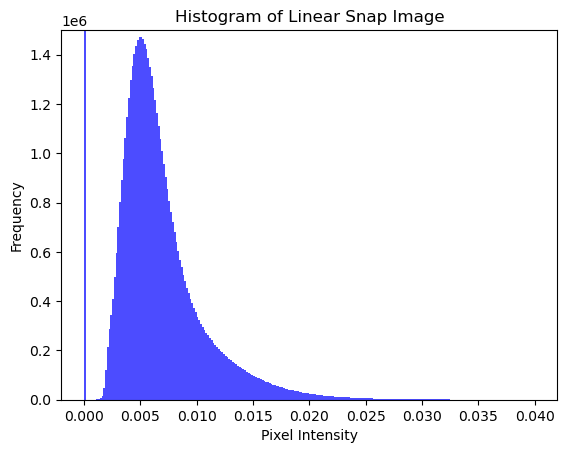

In [22]:
# SNAP SAR from Edwin
snap_image = load_geotiff(snap_sar_egoh_fpath)
# Plot histogram
plt.hist(snap_image.flatten(), bins=256, color='blue', alpha=0.7, range=(0,.04), )
plt.title('Histogram of Linear Snap Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.ylim((0, .15 * 1E7))
plt.show()

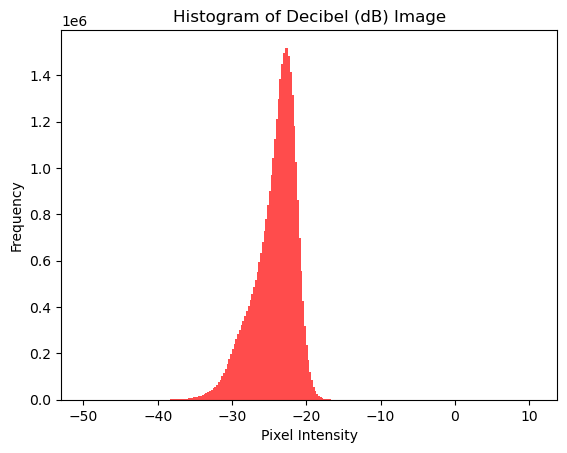

In [25]:
hyp3_image = load_geotiff(hyp3_sar_fpath)
# Plot histogram
plt.hist(hyp3_image.flatten(), bins=256, color='red', alpha=0.7)
plt.title('Histogram of Decibel (dB) Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

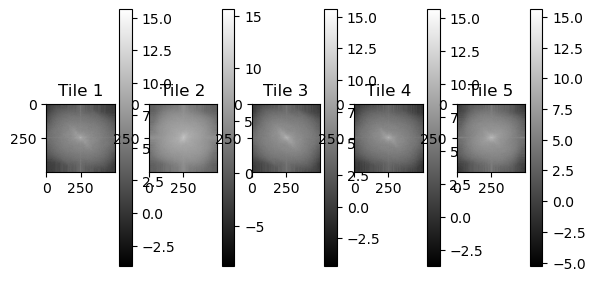

In [26]:
tiles_hyp3 = sample_tiles(hyp3_image, tile_size=500, num_tiles=5)
analyze_tiles(tiles_hyp3)

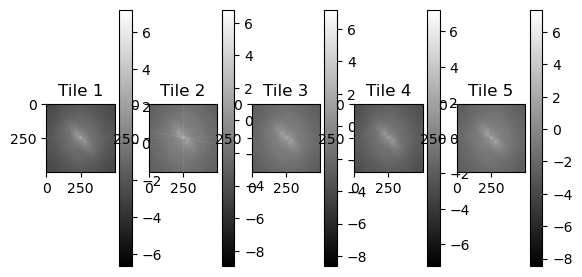

In [27]:
tiles_snap = sample_tiles(snap_image, tile_size=500, num_tiles=5)
analyze_tiles(tiles_snap)

In [9]:
def sample_tiles(image, tile_size=500, num_tiles=5):
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def compute_power_spectrum(image, num_bins=100):
    # Apply a window function to reduce edge effects
    window = windows.hamming(image.shape[0])[:, None] * windows.hamming(image.shape[1])
    image_windowed = image * window

    # Perform FFT
    fft_result = fft2(image_windowed)
    fft_result = fftshift(fft_result)
    
    # Compute the power spectrum
    power_spectrum_2d = np.abs(fft_result) ** 2
    
    # Create frequency bins
    y_freqs = np.fft.fftfreq(image.shape[0])
    x_freqs = np.fft.fftfreq(image.shape[1])
    y_freqs = fftshift(y_freqs)
    x_freqs = fftshift(x_freqs)
    
    # Compute radial frequency bins
    y, x = np.meshgrid(y_freqs, x_freqs, indexing='ij')
    r = np.sqrt(x**2 + y**2)
    r = r.flatten()
    power_spectrum_2d = power_spectrum_2d.flatten()
    
    # Aggregate power in radial frequency bins
    freq_bins = np.linspace(0, np.max(r), num=num_bins)
    power_spectrum, _ = np.histogram(r, bins=freq_bins, weights=power_spectrum_2d)
    
    # Normalize the power spectrum
    power_spectrum /= np.histogram(r, bins=freq_bins)[0]
    
    # Convert power spectrum to log scale
    power_spectrum = np.log10(power_spectrum + 1)
    
    # Apply smoothing to the power spectrum
    power_spectrum_smooth = np.convolve(power_spectrum, np.ones(5)/5, mode='same')
    
    return freq_bins[:-1], power_spectrum_smooth

def plot_frequency_power(freq_bins, power_spectrum, label):
    plt.plot(freq_bins, power_spectrum, label=label)




/var/folders/gn/dtxs0nz95d12sr0m6vrm7f6r0000gq/T/ipykernel_67239/233563419.py:51: RuntimeWarning: invalid value encountered in divide
  power_spectrum /= np.histogram(r, bins=freq_bins)[0]


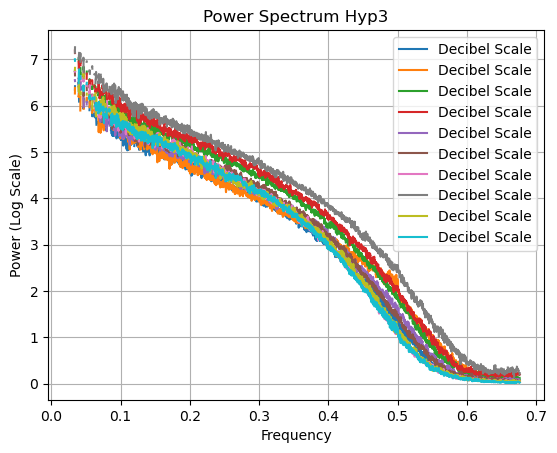

In [48]:
# Sample random tiles
tiles = sample_tiles(hyp3_img, tile_size=500, num_tiles=10)

# Process and analyze the tiles
for tile in tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=5000)
    plot_frequency_power(freq_bins, power_spectrum, label='Decibel Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Power Spectrum Hyp3')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/gn/dtxs0nz95d12sr0m6vrm7f6r0000gq/T/ipykernel_67239/233563419.py:51: RuntimeWarning: invalid value encountered in divide
  power_spectrum /= np.histogram(r, bins=freq_bins)[0]


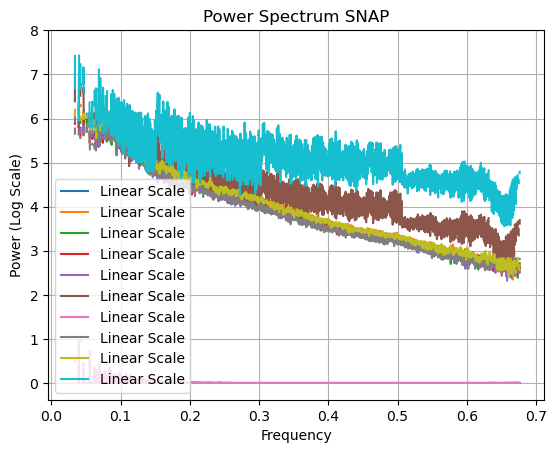

In [49]:
snap_image_log10 = 10 * np.log10(snap_image + 1e-10)
tiles = sample_tiles(snap_image_log10, tile_size=500, num_tiles=10)

# Process and analyze the tiles
for tile in tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=5000)
    plot_frequency_power(freq_bins, power_spectrum, label='Linear Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Power Spectrum SNAP')
plt.legend()
plt.grid(True)
plt.show()
